In [56]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,accuracy_score
from sklearn.preprocessing import OneHotEncoder


In [137]:
#now we do it for football.csv file
df = pd.read_csv('./titatnic.csv')
df=df.drop('Passengerid',axis=1)
df=df.dropna(axis=0)
df.corr()
y = df.pop('2urvived').to_numpy()
df=df.drop(['zero','zero.1','zero.2','zero.3','zero.4','zero.5','zero.6','zero.7','zero.8','zero.9','zero.10','zero.11','zero.12','zero.13','zero.14','zero.15','zero.16','zero.17','zero.18'],axis=1)
X = df.to_numpy() 
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [138]:
X_train=X_train.reshape(X_train.shape[1],X_train.shape[0])
X_test=X_test.reshape(X_test.shape[1],X_test.shape[0])

In [59]:
def sigmoid(z):
        return 1 / (1 + np.exp(-z))

In [60]:
layer_sizes=[7,4,3,1]
weights=[]
biases=[]
for i in range(1, len(layer_sizes)):
    weights.append(np.random.rand(layer_sizes[i], layer_sizes[i-1]))  # Weights for each layer
    biases.append(np.zeros(shape=(layer_sizes[i],1))) 

In [61]:
weights[0].T.shape,weights[1].T.shape,weights[2].T.shape

((7, 4), (4, 3), (3, 1))

In [62]:
layers=3
weights = []
biases = []
for i in range(1, len(layer_sizes)):
    weights.append(np.random.rand(layer_sizes[i], layer_sizes[i-1]))  # Weights for each layer
    biases.append(np.zeros(shape=(layer_sizes[i],1))) 
z = [0] * layers
a = [0] * layers

In [63]:
weights[0].shape

(4, 7)

In [64]:
weights[1].T.shape,biases[1].shape

((4, 3), (3, 1))

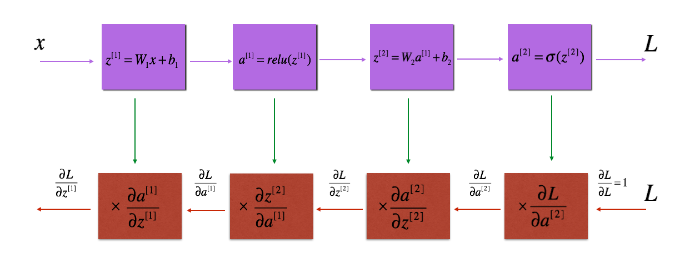

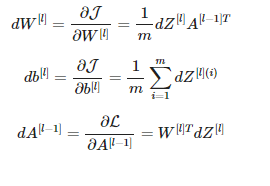

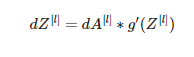

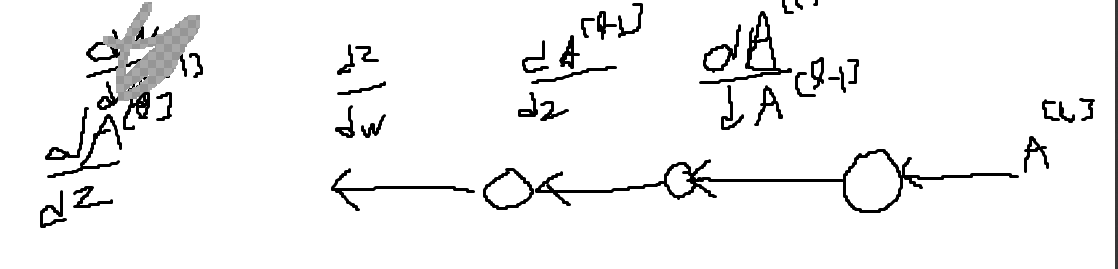

In [142]:
class NeuralNet:
    def __init__(self,layer_sizes, learning_rate,lamb=0.01,alpha=0.01):
        self.layers=len(layer_sizes)-1
        self.weights = []
        self.biases = []
        # for i in range(1,self.layers+1):
        #     self.weights.append(np.random.rand(layer_sizes[i], layer_sizes[i-1]))  # Weights for each layer
        #     self.biases.append(np.zeros(shape=(layer_sizes[i],1))) 
        for i in range(1, self.layers + 1):
            # Xavier initialization: weights are initialized with a variance of 2 / (n_in + n_out)
            n_in, n_out = layer_sizes[i - 1], layer_sizes[i]
            xavier_stddev = np.sqrt(2.0 / (n_in + n_out))
            self.weights.append(np.random.randn(n_out, n_in) * xavier_stddev)  # Normal distribution
            self.biases.append(np.zeros((n_out, 1)))

        self.learning_rate = learning_rate
        self.z = [0] * self.layers
        self.a = [0] * self.layers
        self.lambda_reg=lamb
        self.alpha=alpha
    def forward(self,X):
        for i in range(self.layers):
            #print(i)
            if i==0:
                #print(self.weights[i].shape,X.shape,self.biases[i].shape)
                self.z[i],self.a[i]=self.linear_forward(X,self.weights[i],self.biases[i],'relu')
            elif i==self.layers-1:
                self.z[i],self.a[i]=self.linear_forward(self.a[i-1],self.weights[i],self.biases[i],'sigmoid')
                #self.a[i]=self.z[i]
            else:
                self.z[i],self.a[i]=self.linear_forward(self.a[i-1],self.weights[i],self.biases[i],'relu')
            #if i!=0:
                #print(self.weights[i].shape,self.a[i-1].shape,self.biases[i].shape)
            #print(self.z[i].shape)
        return self.a[-1]
    def backward_propogate(self,Y,X):
        layers=self.layers-1
        gradA=[0]*self.layers
        gradb=[0]*self.layers
        gradW=[0]*self.layers
        #print(gradA)
        #print(self.a[-1])
        for l in range(self.layers):
            gradW[l] += (self.lambda_reg / X.shape[1]) * self.weights[l]  # Adding L2 regularization term to gradient
        Y=Y.reshape(self.a[-1].shape)
        epsilon = 1e-8
        dJA = -(np.divide(-Y, self.a[-1] + epsilon) + np.divide(1 - Y, 1 - self.a[-1] + epsilon))
        
        # y - 1/yhat - 1-y/1-yhat
        ##print(dJA.shape,self.a[self.layers-1].shape)
        #print(layers-1)
        gradA[layers-1], gradW[layers], gradb[layers] = self.linear_backward(dJA=dJA, Z=self.z[layers],A_prev=self.a[layers-1],W=self.weights[layers],b=self.biases[layers],activation='sigmoid')
        ##print(gradA[1].shape)
        for l in reversed(range(self.layers-1)):
            #print(l)
            if l==0:
                dA_prev_temp, dW_temp, db_temp = self.linear_backward(gradA[l],self.z[l],X,self.weights[l],self.biases[l] , activation = "relu")
            else:
                dA_prev_temp, dW_temp, db_temp = self.linear_backward(gradA[l],self.z[l],self.a[l-1],self.weights[l],self.biases[l] , activation = "relu")
            gradA[l-1] = dA_prev_temp
            gradW[l] = dW_temp
            gradb[l] = db_temp
        gradW = self.clip_gradients(gradW, 1.0)
        gradb = self.clip_gradients(gradb, 1.0)
        return gradW,gradb
    
    def clip_gradients(self, grads,clip_value):
        clipped_grads = []
        for grad in grads:
            clipped_grads.append(np.clip(grad, -clip_value, clip_value))
        return clipped_grads

    def optimize(self, gradW, gradb):
        # Clip gradients

        # Update weights and biases with clipped gradients
        for l in range(self.layers):
            self.weights[l] -= self.learning_rate * gradW[l]
            self.biases[l] -= self.learning_rate * gradb[l]

        return self.weights, self.biases
    
    def predict(self,X):
        a=self.a.copy()
        z=self.z.copy()
        weights=self.weights.copy()
        biases=self.biases.copy()
        for i in range(self.layers):
            #print(weights[i].shape,X.shape,biases[i].shape)
            if i==0:
                z[i],a[i]=self.linear_forward(X,weights[i],biases[i],'relu')
            elif i==self.layers-1:
                z[i],a[i]=self.linear_forward(a[i-1],weights[i],biases[i],'sigmoid')
            else:
                z[i],a[i]=self.linear_forward(a[i-1],weights[i],biases[i],'relu')
            #print(weights[i].shape,a[i-1].shape,biases[i].shape)
        return z[-1]
    def linear_backward(self,dJA,Z,A_prev,W,b, activation):
        m=A_prev.shape[1]
        #dJ/dZ = dJ/dA * dA/dZ
        #print(f"dJA          Z       A_prev      W      b")
        #print(f"{dJA.shape} {Z.shape} {A_prev.shape} {W.shape} {b.shape}")
        if activation == "relu":
            dJZ = np.array(dJA, copy=True)
            #dA/dZ Z>0 =1 else 0
            dJZ[Z <= 0] = 0
        elif activation == "sigmoid":
            s=1/(1+np.exp(-Z))
            dAZ=s*(1-s)
            dJZ = dJA*dAZ
        elif activation == "leaky_relu":
            dJZ = dJA * self.leaky_relu_derivative(Z, self.alpha)
        elif activation=='':
            dJZ=dJA
        #Z= WA+B
        #dZ/dW = A
        #dJ/dW=dZ/dW * dL/dZ
        #1/m to stabalize
        dJW=(1/m) * np.dot(dJZ, A_prev.T)
        #print("dJW = dJZ * A[l-1]")
        #print(f"{dJW.shape}= {dJZ.shape}*{A_prev.T.shape}")
        #print(f"W = {W.shape}")
        #dZ/db = 1
        #dJ/db=dJ/dZ *dZ/db
        dJb = (1/m)*np.sum(dJZ,axis=1,keepdims=True)
        #print("dJb = dJZ*1")
        #print(f"{dJW.shape}= {dJZ.shape}")        
        #dZ/dA =W
        #dJ/dA = dJ/dZ *dZ/dA
        dJA = (1/m)*np.dot(W.T,dJZ)
        #print("dJA = dZ/dA* dJ/dZ")
        #print(f"{dJA.shape}= {W.T.shape}*{dJZ.shape}")        
        ##print(dJb.shape,b.shape)
        assert (dJA.shape == A_prev.shape)
        assert (dJW.shape == W.shape)
        assert (dJb.shape == b.shape)

        return dJA, dJW, dJb 

    def linear_forward(self,A, W, b,activation=''):
        #A -- activations from previous layer (or input data): (size of previous layer, number of examples)
        #W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
        #b -- bias vector, numpy array of shape (size of the current layer, 1)
        ##print(W.shape,A.shape,b.shape)
        Z=np.dot(W,A)+b
        #7,1045
        #1045,1
        #7,1
        ##print(Z.shape)
        assert(Z.shape == (W.shape[0], A.shape[1]))
        if activation=='sigmoid':
            n=self.sigmoid(Z)
        elif activation=='relu':
            n=self.relu(Z)
        elif activation == 'leaky_relu':
            n=self.leaky_relu(Z, self.alpha)
        return Z, n

    def Cost(self, yhat, Y):
        m = Y.shape[0]
        cost = ((Y - yhat) ** 2).mean()
        L2_regularization_cost = (self.lambda_reg / (2 * m)) * sum([np.sum(np.square(w)) for w in self.weights])
        return cost + L2_regularization_cost
    @staticmethod
    def sigmoid_derivation(a):
        return a*(1-a)

    @staticmethod
    def leaky_relu(z, alpha=0.01):
        return np.where(z > 0, z, alpha * z)
    @staticmethod
    def leaky_relu_derivative(z, alpha=0.01):
        return np.where(z > 0, 1, alpha)

    @staticmethod
    def relu(z):
        return np.maximum(0,z)
    
    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

#Patch used epsilon smoothening for divide by 0 errors

In [145]:
nn=NeuralNet(layer_sizes=[X_train.shape[0],5,8,1],learning_rate=0.01)

In [146]:
steps=2000
for i in range(steps):
    nn.forward(X_train)
    gradsW,gradsb=nn.backward_propogate(y_train,X_train)
    nn.optimize(gradsW,gradsb)
    pred=nn.predict(X_test)
    #print(pred.shape)
    y_pred = np.where(pred >= 0.5, 1, 0).flatten()
    #print(y_pred.shape,y_test.shape)
    print(accuracy_score(nn.a[-1],y_train),accuracy_score(y_pred,y_test))

ValueError: Found input variables with inconsistent numbers of samples: [1, 1045]

In [120]:
nn=NeuralNet(layer_sizes=[X_train.shape[0],16,8,4,1],learning_rate=0.01)
steps=1
for i in range(steps):
    nn.forward(X_train)
    gradsW,gradsb=nn.backward_propogate(y_train,X_train)
    nn.optimize(gradsW,gradsb)
    pred=nn.predict(X_test)
    #print(pred.shape)
    y_pred = np.where(pred >= 0.5, 1, 0).flatten()
    #print(y_pred.shape,y_test.shape)
    print(accuracy_score(y_pred,y_test))

0.732824427480916


In [121]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [122]:
df = pd.read_csv('./house_prices.csv')
df=df.drop("Unnamed: 0",axis=1)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['location']=label_encoder.fit_transform(df['location'])
df['city']=label_encoder.fit_transform(df['city'])
df['purpose']=label_encoder.fit_transform(df['purpose'])
df['property_type']=label_encoder.fit_transform(df['property_type'])
df['Area_in_Marla']=label_encoder.fit_transform(df['Area_in_Marla'])
df=df.drop('location',axis=1)
from sklearn.preprocessing import MinMaxScaler
y=df.pop('price').to_numpy()
scaler = MinMaxScaler()
X = scaler.fit_transform(df)

# Convert the scaled data back to a DataFrame
X = pd.DataFrame(X, columns=df.columns)
X=X.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train=X_train.reshape(X_train.shape[1],X_train.shape[0])
X_test=X_test.reshape(X_test.shape[1],X_test.shape[0])


In [123]:
#now we do it for football.csv file
df = pd.read_csv('football.csv')
df=df.drop('Team',axis=1)
df.corr()
y = df.pop('Points').to_numpy()
X = df.to_numpy() 
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train=X_train.reshape(X_train.shape[1],X_train.shape[0])
X_test=X_test.reshape(X_test.shape[1],X_test.shape[0])

In [124]:
class NeuralNet:
    def __init__(self,layer_sizes, learning_rate,lamb=0.01,alpha=0.01):
        self.layers=len(layer_sizes)-1
        self.weights = []
        self.biases = []
        # for i in range(1,self.layers+1):
        #     self.weights.append(np.random.rand(layer_sizes[i], layer_sizes[i-1]))  # Weights for each layer
        #     self.biases.append(np.zeros(shape=(layer_sizes[i],1))) 
        for i in range(1, self.layers + 1):
            # Xavier initialization: weights are initialized with a variance of 2 / (n_in + n_out)
            n_in, n_out = layer_sizes[i - 1], layer_sizes[i]
            xavier_stddev = np.sqrt(2.0 / (n_in + n_out))
            self.weights.append(np.random.randn(n_out, n_in) * xavier_stddev)  # Normal distribution
            self.biases.append(np.zeros((n_out, 1)))

        self.learning_rate = learning_rate
        self.z = [0] * self.layers
        self.a = [0] * self.layers
        self.lambda_reg=lamb
        self.alpha=alpha
    def forward(self,X):
        for i in range(self.layers):
            #if i==0:
                #print(self.weights[i].shape,X.shape,self.biases[i].shape)
            if i==0:
                self.z[i],self.a[i]=self.linear_forward(X,self.weights[i],self.biases[i],'leaky_relu')
            elif i==self.layers-1:
                self.z[i],self.a[i]=self.linear_forward(self.a[i-1],self.weights[i],self.biases[i])
                self.a[i]=self.z[i]
            else:
                self.z[i],self.a[i]=self.linear_forward(self.a[i-1],self.weights[i],self.biases[i],'leaky_relu')
            #if i!=0:
                #print(self.weights[i].shape,self.a[i-1].shape,self.biases[i].shape)
            #print(self.z[i].shape)
        return self.a[-1]
    def backward_propogate(self,Y,X):
        layers=self.layers-1
        gradA=[0]*self.layers
        gradb=[0]*self.layers
        gradW=[0]*self.layers
        #print(gradA)
        #print(self.a[-1])
        for l in range(self.layers):
            gradW[l] += (self.lambda_reg / X.shape[1]) * self.weights[l]  # Adding L2 regularization term to gradient
        Y=Y.reshape(self.a[-1].shape)
        epsilon = 1e-8
        dJA =(self.a[-1] - Y)
        ##print(dJA.shape,self.a[self.layers-1].shape)
        #print(layers-1)
        gradA[layers-1], gradW[layers], gradb[layers] = self.linear_backward(dJA=dJA, Z=self.z[layers],A_prev=self.a[layers-1],W=self.weights[layers],b=self.biases[layers],activation='')
        ##print(gradA[1].shape)
        for l in reversed(range(self.layers-1)):
            #print(l)
            if l==0:
                dA_prev_temp, dW_temp, db_temp = self.linear_backward(gradA[l],self.z[l],X,self.weights[l],self.biases[l] , activation = "leaky_relu")
            else:
                dA_prev_temp, dW_temp, db_temp = self.linear_backward(gradA[l],self.z[l],self.a[l-1],self.weights[l],self.biases[l] , activation = "leaky_relu")
            gradA[l-1] = dA_prev_temp
            gradW[l] = dW_temp
            gradb[l] = db_temp
        gradW = self.clip_gradients(gradW, 1.0)
        gradb = self.clip_gradients(gradb, 1.0)
        return gradW,gradb
    
    def clip_gradients(self, grads,clip_value):
        clipped_grads = []
        for grad in grads:
            clipped_grads.append(np.clip(grad, -clip_value, clip_value))
        return clipped_grads

    def optimize(self, gradW, gradb):
        # Clip gradients

        # Update weights and biases with clipped gradients
        for l in range(self.layers):
            self.weights[l] -= self.learning_rate * gradW[l]
            self.biases[l] -= self.learning_rate * gradb[l]

        return self.weights, self.biases
    
    def predict(self,X):
        a=self.a.copy()
        z=self.z.copy()
        weights=self.weights.copy()
        biases=self.biases.copy()
        for i in range(self.layers):
            #print(weights[i].shape,X.shape,biases[i].shape)
            if i==0:
                z[i],a[i]=self.linear_forward(X,weights[i],biases[i],'leaky_relu')
            elif i==self.layers-1:
                z[i],a[i]=self.linear_forward(a[i-1],weights[i],biases[i])
            else:
                z[i],a[i]=self.linear_forward(a[i-1],weights[i],biases[i],'leaky_relu')
            #print(weights[i].shape,a[i-1].shape,biases[i].shape)
        return z[-1]
    def linear_backward(self,dJA,Z,A_prev,W,b, activation):
        m=A_prev.shape[1]
        #dJ/dZ = dJ/dA * dA/dZ
        #print(f"dJA          Z       A_prev      W      b")
        #print(f"{dJA.shape} {Z.shape} {A_prev.shape} {W.shape} {b.shape}")
        if activation == "relu":
            dJZ = np.array(dJA, copy=True)
            #dA/dZ Z>0 =1 else 0
            dJZ[Z <= 0] = 0
        elif activation == "sigmoid":
            s=1/(1+np.exp(-Z))
            dAZ=s*(1-s)
            dJZ = dJA*dAZ
        elif activation == "leaky_relu":
            dJZ = dJA * self.leaky_relu_derivative(Z, self.alpha)
        elif activation=='':
            dJZ=dJA
        #Z= WA+B
        #dZ/dW = A
        #dJ/dW=dZ/dW * dL/dZ
        #1/m to stabalize
        dJW=(1/m) * np.dot(dJZ, A_prev.T)
        #print("dJW = dJZ * A[l-1]")
        #print(f"{dJW.shape}= {dJZ.shape}*{A_prev.T.shape}")
        #print(f"W = {W.shape}")
        #dZ/db = 1
        #dJ/db=dJ/dZ *dZ/db
        dJb = (1/m)*np.sum(dJZ,axis=1,keepdims=True)
        #print("dJb = dJZ*1")
        #print(f"{dJW.shape}= {dJZ.shape}")        
        #dZ/dA =W
        #dJ/dA = dJ/dZ *dZ/dA
        dJA = (1/m)*np.dot(W.T,dJZ)
        #print("dJA = dZ/dA* dJ/dZ")
        #print(f"{dJA.shape}= {W.T.shape}*{dJZ.shape}")        
        ##print(dJb.shape,b.shape)
        assert (dJA.shape == A_prev.shape)
        assert (dJW.shape == W.shape)
        assert (dJb.shape == b.shape)

        return dJA, dJW, dJb 

    def linear_forward(self,A, W, b,activation=''):
        #A -- activations from previous layer (or input data): (size of previous layer, number of examples)
        #W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
        #b -- bias vector, numpy array of shape (size of the current layer, 1)
        ##print(W.shape,A.shape,b.shape)
        Z=np.dot(W,A)+b
        ##print(Z.shape)
        assert(Z.shape == (W.shape[0], A.shape[1]))
        if activation=='sigmoid':
            A=self.sigmoid(Z)
        elif activation=='relu':
            A=self.relu(Z)
        elif activation == 'leaky_relu':
            A = self.leaky_relu(Z, self.alpha)
        return Z, A

    def Cost(self, yhat, Y):
        m = Y.shape[0]
        cost = ((Y - yhat) ** 2).mean()
        L2_regularization_cost = (self.lambda_reg / (2 * m)) * sum([np.sum(np.square(w)) for w in self.weights])
        return cost + L2_regularization_cost
    @staticmethod
    def sigmoid_derivation(a):
        return a*(1-a)

    @staticmethod
    def leaky_relu(z, alpha=0.01):
        return np.where(z > 0, z, alpha * z)
    @staticmethod
    def leaky_relu_derivative(z, alpha=0.01):
        return np.where(z > 0, 1, alpha)

    @staticmethod
    def relu(z):
        return np.maximum(0,z)
    
    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

In [132]:
nn=NeuralNet(layer_sizes=[X_train.shape[0],64,32,16,8,1],learning_rate=0.01,lamb=0.000)
steps=1000
for i in range(steps):
    nn.forward(X_train)
    gradsW,gradsb=nn.backward_propogate(y_train,X_train)
    mean_gradsW = [np.mean(gw) for gw in gradsW]
    mean_gradsb = [np.mean(gb) for gb in gradsb]
    #print(f"Step {i+1}, Mean Gradients Weights: {mean_gradsW}, Mean Gradients Biases: {mean_gradsb}")
    #print(f"Step {i+1},  Weights: {nn.weights},  Biases: {nn.biases}")
    nn.optimize(gradsW,gradsb)
    #print(nn.a[-1].shape)
    y_pred=nn.predict(X_test).flatten()
    #print(y_pred.shape,y_test.shape)
    #print(f"Test = {nn.Cost(y_pred,y_test)}")
    print(nn.Cost(nn.a[-1],y_train),nn.Cost(y_pred,y_test))

2578.4771066270014 3597.350239323187
2573.747065328739 3590.5101599956274
2568.6299852287048 3583.411384338452
2563.246711897193 3576.0919683607076
2557.6104015879023 3568.604921042229
2551.7767475839355 3560.870084707193
2545.6111609540767 3552.84523318876
2539.1659168817855 3544.61925577903
2532.536550941583 3536.0329553032216
2525.6027398533197 3526.9531784125716
2518.2353036099125 3517.4904657464867
2510.5793374405475 3507.736440781218
2502.7486570716424 3497.7215021895136
2494.740079256056 3487.4803859394624
2486.3350332705704 3476.803017420819
2477.4624374950504 3465.5153501884884
2468.382354411847 3453.8252419929995
2459.027997567343 3441.8148153696247
2449.359100624086 3429.5414387686446
2439.4694772351354 3416.7981282008122
2429.3571292614943 3403.6449258163702
2419.022472133115 3390.21621944764
2408.46341339518 3376.5196905344424
2397.5138611148327 3362.1869480382898
2385.7956369972085 3347.588867169689
2373.6496976421736 3332.7224379936138
2361.2340883052498 3317.59181161029

In [ ]:
nn.a[-1]

array([[71.00027557, 29.99959215, 40.00088271, 43.98421874, 76.99951688,
        46.000398  , 28.01787453, 66.0024108 , 43.99224431, 50.00641185,
        45.00094864, 42.9988666 , 52.99645251]])